Imports and setup

In [1]:
from SHARED.vf_TD_class import *
import seaborn as sns

stochastic = False
random_starts = False
GAMMA = 1

model_path = "models/SAC/deterministic/best_model_agent_11_abs.zip"
env_path = "models/SAC/deterministic/vecNormEnv_agent_11_abs.pkl"

2024-05-25 09:17:51.127978: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 09:17:51.150797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 09:17:51.150825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 09:17:51.151582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 09:17:51.155671: I tensorflow/core/platform/cpu_feature_guar

In [2]:
my_value_function = value_function_TD(input_dim=12,hidden_dim=128,learning_rate=1e-3,batch_size=1024,buffer_size=200000,tau=0.01,model_path=model_path,env_path=env_path,train_episodes=100)
# obs_log = my_value_function.sim_on_mpc(extra_samples=10,spread = 0.2)
obs_log, obs_next_log, pairs = my_value_function.sim_with_agent(extra_samples=0)
print (len(my_value_function.memory))





100%|██████████| 1920/1920 [00:01<00:00, 1248.62it/s]

1920


Visualizing data points

[0.0035     0.0034992  0.00349847 ... 0.3075209  0.30746868 0.3074162 ]


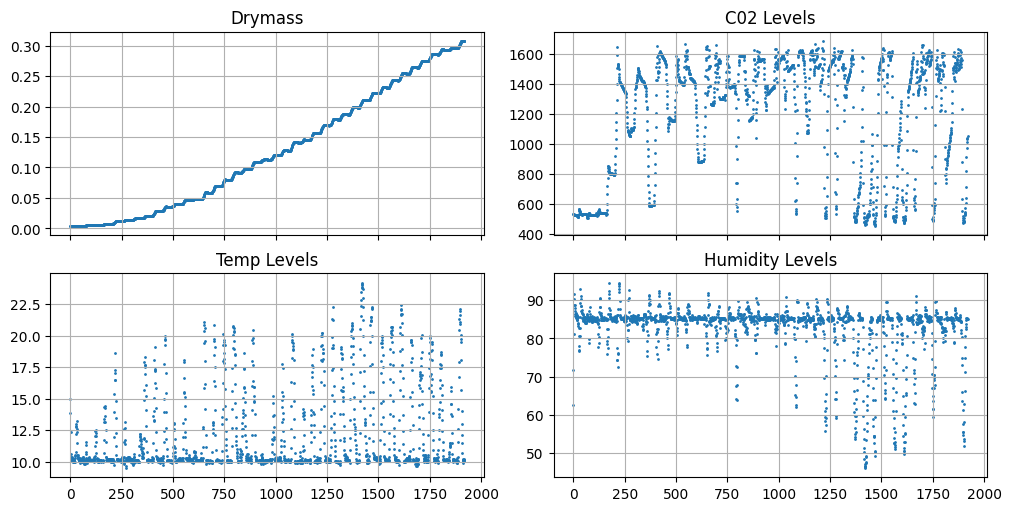

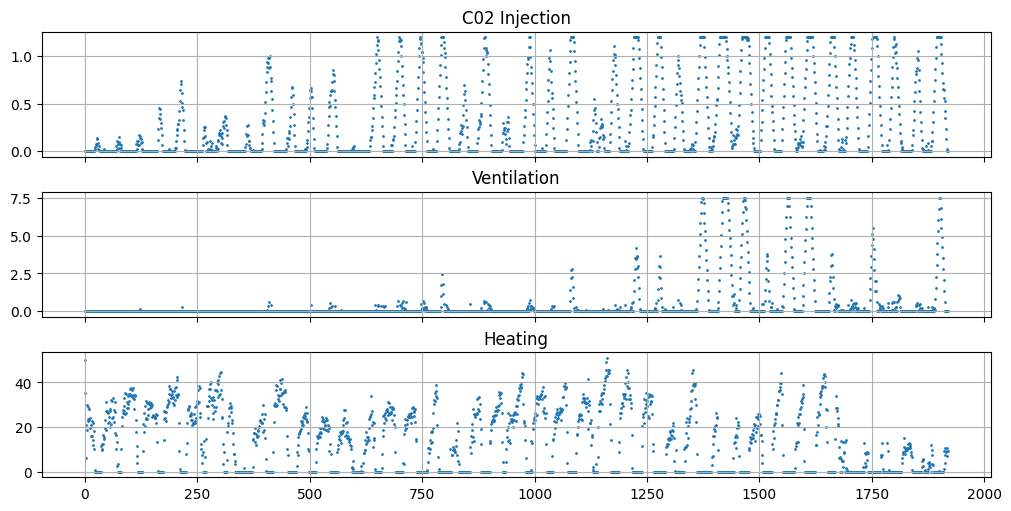

In [3]:
obs_data = np.vstack(obs_log)
y1 = obs_data[:,0]
y2 = obs_data[:,1]
y3 = obs_data[:,2]
y4 = obs_data[:,3]

print (y1)

u1 = obs_data[:,4]
u2 = obs_data[:,5]
u3 = obs_data[:,6]

time = obs_data[:,7]

fig, axs_y = plt.subplots(2,2,sharex=True, sharey=False, layout='constrained',figsize=(10, 5))

axs_y1 = axs_y[0,0]
axs_y1.set_title("Drymass")
axs_y1.scatter(time,y1, s = 1)
axs_y1.grid()

axs_y2 = axs_y[0,1]
axs_y2.set_title("C02 Levels")
axs_y2.scatter(time,y2, s = 1)
axs_y2.grid()

axs_y3 = axs_y[1,0]
axs_y3.set_title("Temp Levels")
axs_y3.scatter(time,y3, s = 1)
axs_y3.grid()

axs_y4 = axs_y[1,1]
axs_y4.set_title("Humidity Levels")
axs_y4.scatter(time,y4, s = 1)
axs_y4.grid()
plt.savefig('figures/sampled_y_td.eps', format='eps')


fig, axs_u = plt.subplots(3,1,sharex=True, sharey=False, layout='constrained',figsize=(10, 5))
axs_u1 = axs_u[0]
axs_u1.set_title("C02 Injection")
axs_u1.scatter(time,u1, s = 1)
axs_u1.grid()

axs_u2 = axs_u[1]
axs_u2.set_title("Ventilation")
axs_u2.scatter(time,u2, s = 1)
axs_u2.grid()

axs_u3 = axs_u[2]
axs_u3.set_title("Heating")
axs_u3.scatter(time,u3, s = 1)
axs_u3.grid()
# plt.savefig('figures/sampled_u_td.eps', format='eps')

In [3]:
my_vf  = value_function_TD(input_dim=12,hidden_dim=128,learning_rate=1e-4,batch_size=128,buffer_size=100000,tau=0.5,model_path=model_path,env_path=env_path,train_episodes=100)
my_vf.memory = copy.deepcopy( my_value_function.memory)
my_vf.train(epochs=500)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [5]:
print (f"Total samples collected:{len(my_vf.memory)}")
print (f"Total training samples:{len(my_vf.training_memory)}")
print (f"Total validation samples:{len(my_vf.validation_memory)}")

Total samples collected:1920
Total training samples:1536
Total validation samples:384


In [6]:
save_path = "models/VF/Deterministic/vf_td.zip"
torch.save (my_vf.neural_net,save_path)

100%|██████████| 1920/1920 [00:01<00:00, 1017.75it/s]


----------------------------  -----------
EPI                (EURO/m2)     4.96257
Total growth       (kg/m2)       0.303865
Total C02 usage    (kg/m2)       1.05686
Total Heating      (kWh)        12.55
Computational Time (s)
Temp violations    (deg)       110.007
C02 violations     (ppm)      3311.43
FINAL PERFORMANCE                4.26665
----------------------------  -----------


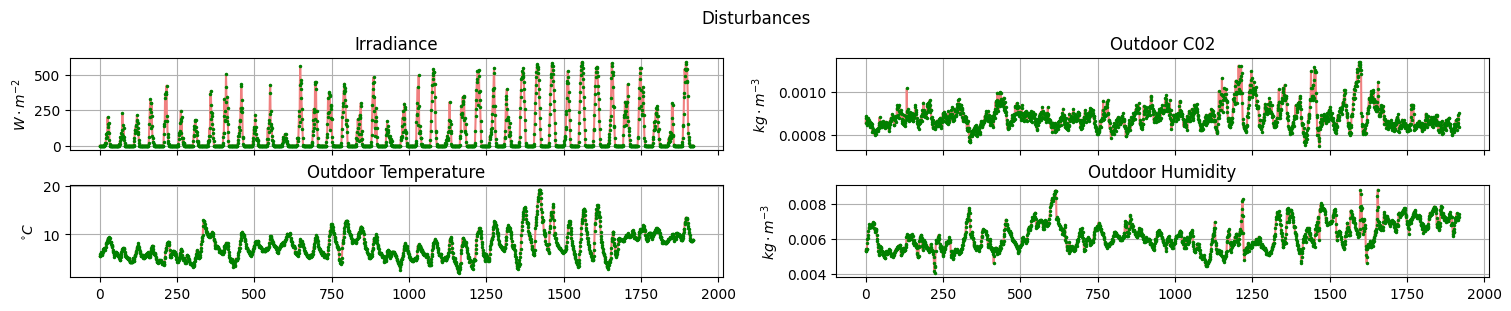

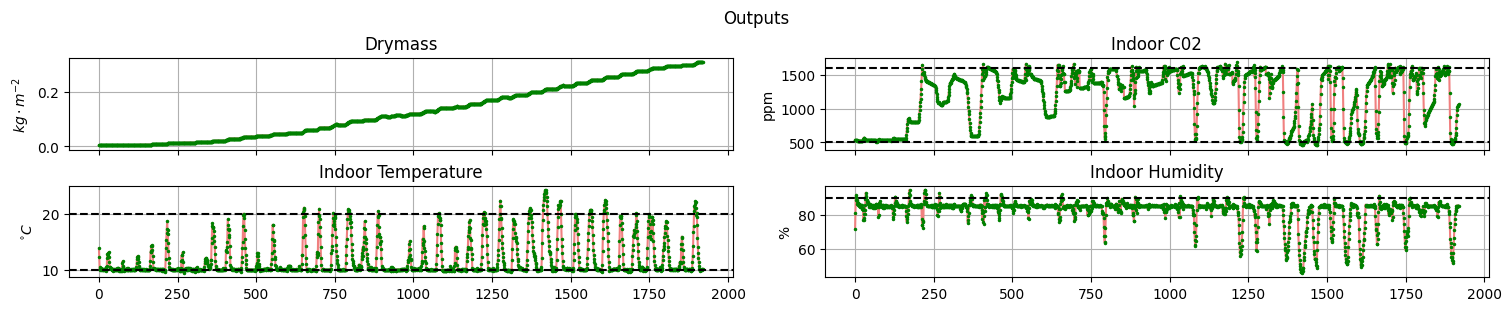

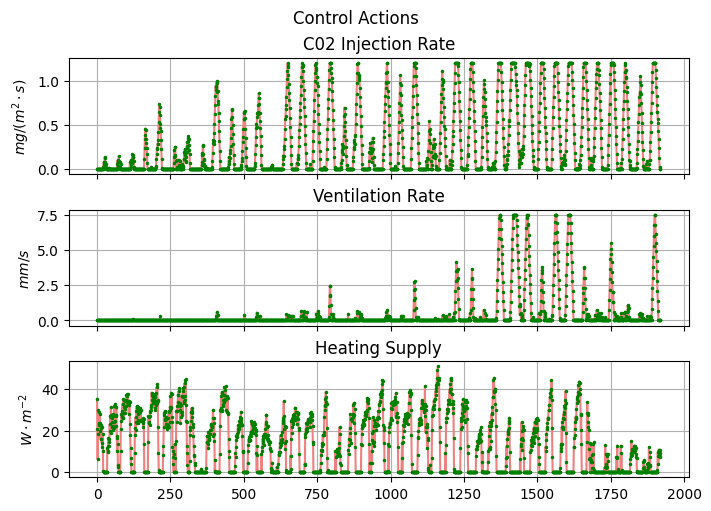

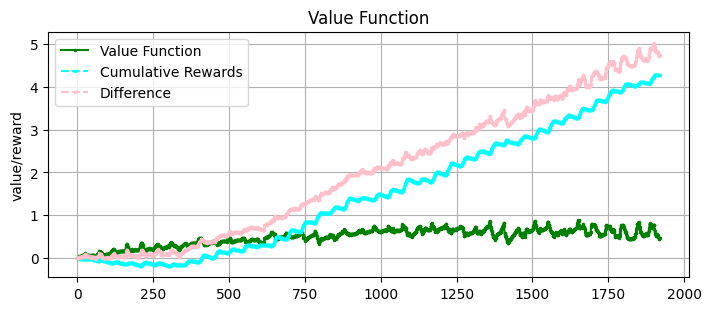

In [7]:
y,u,x = my_vf.test_with_agent()

y1 = np.stack(y)[:,0]
x = np.stack(x)
u = np.stack(u)

In [8]:
x[0,:]

array([3.49919839e-03, 9.99909425e-04, 1.38947825e+01, 8.57995316e-03])

In [9]:
'''Growth rate'''
max_growth = 0.5
min_growth = 0
growth_range = np.linspace(min_growth,max_growth,20)

env = greenhouseEnv()
env.random_starts = False
env.stochastic = False
env.using_mpc = False  
obs, _ =env.reset()

env_norm = greenhouseEnv(use_growth_dif=False)
env_norm = DummyVecEnv([lambda: env_norm])
env_norm = VecNormalize(env_norm, norm_obs = True, norm_reward = False, clip_obs = 10.,gamma=1)
env_norm = env_norm.load(env_path,env_norm)
env_norm.training = False

def vf_heatmap():
    vf_grid = np.zeros((len(growth_range),max_steps))
    for i in range(max_steps):
        for indx,growth in enumerate(growth_range):
            log = []
            env.set_env_state(x[i,:],x[i,:],u[i,:],i)
            for j in range (0,20):
                            
                obs,x_now,u_opt = env.sample_obs(0.1)
                log.append(obs)
            
            # print (log)
            log = np.stack(log)
            
            obs = np.mean(log,axis=0)
            obs[0] = growth
            obs[7] = i
            
            bounds_min = y1[i]*(1-0.8) - 0.01
            bounds_max = y1[i]*(1+0.7) + 0.1
            
            if growth < bounds_max and growth> bounds_min:
                obs_norm = env_norm.normalize_obs(obs)
                obs2store = obs_norm #normalizeState(np.array([obs[0],obs[7]]),np.array([x_min[0],0]), np.array([x_max[0],max_steps]))
                value= my_vf.evaluate_value(obs2store)         
            else:
                value = None
            
            vf_grid[indx][i] = value
            
    mask = np.arange(len(growth_range)) % 1 == 0
    yticks = np.where(mask, np.round(growth_range*1000,3), None)

    ax = sns.heatmap(vf_grid, yticklabels=yticks)

    ax.invert_yaxis()  # Invert y-axis on the heatmap object
    plt.show()


vf_heatmap()

KeyboardInterrupt: 